# Pitch Quality by Pitch Type

# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [4-Seam Analysis](#4-Seam-Analysis)
    - [Top 10 4-Seam xQual](#Top-10-4-Seam-xQual)
    - [4-Seam HB & VB](#4-Seam-HB-&-VB)
- [Cutter Analysis](#Cutter-Analysis)
    - [Top 10 Cutter xQual](#Top-10-Cutter-xQual)
    - [Cutter HB & VB](#Cutter-HB-&-VB)
- [Sinker Analysis](#Sinker-Analysis)
    - [Top 10 Sinker xQual](#Top-10-Sinker-xQual)
    - [Sinker HB & VB](#Sinker-HB-&-VB)
- [Slider Analysis](#Slider-Analysis)
    - [Top 10 Slider xQual](#Top-10-Slider-xQual)
    - [Slider HB & VB](#Slider-HB-&-VB)
- [Curveball Analysis](#Curveball-Analysis)
    - [Top 10 Curveball xQual](#Top-10-Curveball-xQual)
    - [Curveball HB & VB](#Curveball-HB-&-VB)
- [Changeup Analysis](#Changeup-Analysis)
    - [Top 10 Changeup xQual](#Top-10-Changeup-xQual)
    - [Changeup HB & VB](#Changeup-HB-&-VB)

# Imports

In [1]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

xrv = pd.read_csv('../data/xrv-pitches.csv', index_col = [0])
rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv.shape)
xrv.head()

(680920, 11)


,player_name,p_throws,pitch_type,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,n_pitches,xRV
0,"Gsellman, Robert",R,FF,93.4,8.16,10.68,6.3,28.8,0.00,1,0.00998
1,"Martin, Chris",R,FF,95.3,3.24,13.56,6.7,40.1,0.00,1,-0.02246
2,"Martin, Chris",R,FF,94.9,9.00,14.16,6.6,40.1,-0.18,1,-0.12516
3,"Hembree, Heath",R,FF,93.5,12.12,17.28,6.7,20.1,-0.11,1,-0.03124
4,"Hembree, Heath",R,FF,95.5,12.48,18.24,6.6,20.1,0.00,1,0.00474


In [3]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,6.2,43.3,7.9,3.8,6.2,3.0
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,6.4,40.8,0.2,0.2,-1.4,-1.3
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,6.3,28.7,2.5,0.8,4.5,1.4
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,5.8,31.0,3.2,3.6,0.9,1.0
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,6.7,34.5,4.7,3.7,2.9,2.3


# Preprocessing

In [4]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

ff_stats = xrv.loc[xrv['pitch_type'] == 'FF']
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [5]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'release_extension', 'rv']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

print(vif_data.sort_values(by = 'VIF'))

             feature         VIF
8                 rv    1.000453
2              pfx_x    1.382019
4      release_pos_x    2.456613
3              pfx_z    3.112541
6          arm_angle    8.860240
1          spin_rate   50.638150
5      release_pos_z  127.143976
7  release_extension  162.936236
0               velo  298.870800


# Analysis

### Run Value for Ball in Play by Events

In [6]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.770147,1.041,1.259,0.770147
1,field_error,0.445453,0.716,0.866,0.445453
2,field_out,-0.271400,0.000,0.000,-0.271400
3,game_advisory,-0.076667,0.194,0.235,-0.076667
4,hit_by_pitch,0.359255,0.630,0.762,0.359255
5,home_run,1.385794,1.657,2.003,1.385794
6,single,0.474625,0.746,0.902,0.474625
7,triple,1.062984,1.334,1.613,1.062984
8,walk,0.332287,0.603,0.729,0.332287


### Run Value by Count

In [7]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009612,0.008308
1,0-1,0.265,-0.018634,0.007309
2,0-2,0.197,-0.067630,-0.048850
3,1-0,0.356,-0.008224,0.009572
4,1-1,0.300,-0.021001,0.012828
...,...,...,...,...
8,2-2,0.269,-0.105299,-0.045864
9,3-0,0.540,0.006415,0.122922
10,3-1,0.477,-0.006323,0.116874
11,3-2,0.379,0.011064,0.038036


### Average Run Value by Pitch Type

In [8]:
xrv.groupby(['pitch_type'], as_index = False, sort = False)['rv', 'xRV'].mean()

,pitch_type,rv,xRV
0,FF,0.005478,0.008926
1,FC,0.003665,0.006626
2,SI,0.008420,0.011914
3,SL,-0.007693,-0.005802
4,CU,-0.007629,-0.005919
5,CH,-0.003034,-0.000706


In [9]:
rv_pitches.groupby(['pitch_type'], as_index = False, sort = False)['RV/100', 'xRV/100'].mean()

,pitch_type,RV/100,xRV/100
0,FF,1.298381,1.612578
1,FC,1.525664,1.239823
2,SI,1.286640,1.630845
3,SL,0.019041,0.218895
4,CU,0.529274,0.671368
5,CH,0.212883,0.357669


# 4-Seam Analysis

In [10]:
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

ff_r_avg = ff_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
ff_l_avg = ff_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
ff_avg = pd.concat([ff_r_avg, ff_l_avg], ignore_index = True)
ff_avg = ff_avg.round(1)
ff_avg.head()

,pitch_type,p_throws,velo,pfx_x,pfx_z,release_extension,arm_angle
0,FF,R,94.1,7.1,16.1,6.4,31.3
1,FF,L,92.8,-7.5,16.2,6.3,59.2


In [11]:
ff_stats[['rv', 'xRV']].describe()

,rv,xRV
count,249682.000000,249682.000000
mean,0.005478,0.008926
std,0.249677,0.142513
min,-1.780000,-1.157400
25%,0.000000,-0.019840
50%,0.000000,0.000180
75%,0.000000,0.022520
max,3.760000,2.503340


### Top 10 4-Seam xQual

In [12]:
ff_stats['RV/100'] = ((ff_stats['rv'] / ff_stats['n_pitches']) * 100)
ff_stats['xRV/100'] = ((ff_stats['xRV'] / ff_stats['n_pitches']) * 100)

cols = list(ff_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
ff_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    ff_stats[col_zscore] = ((ff_stats[col] - ff_stats[col].mean()) / ff_stats[col].std(ddof = 0) * -1)

stats = ff_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                         as_index = False)['n_pitches', 'rv', 'xRV', 'rv_zscore', 'xRV_zscore'].sum()

ff_stats = pd.merge(ff_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
ff_stats['Qual'] = ff_stats['rv_zscore_y'] + 100
ff_stats['xQual'] = ff_stats['xRV_zscore_y'] + 100
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

q_stats = ff_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                             'RV/100', 'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
ff_leaders = stats.sort_values(by = ['xQual'], ascending = False)
ff_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
440,"Matzek, Tyler",L,FF,753,96.03,-4.87,17.97,6.33,53.8,-11.05,-1.47,160.78,-17.06,-2.27,266.85
584,"Ray, Robbie",L,FF,1864,94.78,-8.18,17.13,6.48,79.2,-14.01,-0.75,197.01,-5.64,-0.30,256.33
137,"Cole, Gerrit",R,FF,1397,97.67,11.99,17.96,6.57,34.6,-10.88,-0.78,174.23,-9.02,-0.65,250.82
642,"Scherzer, Max",R,FF,1316,94.30,10.61,16.03,6.23,48.3,-11.66,-0.89,175.57,-8.14,-0.62,239.53
416,"Lynn, Lance",R,FF,1051,93.99,6.03,14.94,6.34,46.7,-10.63,-1.01,165.63,-10.35,-0.99,238.47
93,"Buehler, Walker",R,FF,1400,95.35,3.05,18.00,6.39,17.5,-10.02,-0.72,170.85,-7.05,-0.50,237.13
765,"Wheeler, Zack",R,FF,1353,97.17,7.65,15.91,7.20,29.7,-11.49,-0.85,175.70,-7.33,-0.54,236.20
424,"Mahle, Tyler",R,FF,1695,94.03,12.08,17.13,6.61,33.1,-3.74,-0.22,152.17,-3.49,-0.21,230.66
272,"Green, Chad",R,FF,854,95.69,4.47,19.31,6.65,28.1,-9.90,-1.16,158.39,-10.13,-1.19,224.55
607,"Romano, Jordan",R,FF,641,97.59,5.32,18.19,7.21,33.2,-11.06,-1.73,158.36,-11.74,-1.83,222.54


In [13]:
ff_leaders.loc[ff_leaders['player_name'] == 'Cole, Gerrit']

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
137,"Cole, Gerrit",R,FF,1397,97.67,11.99,17.96,6.57,34.6,-10.88,-0.78,174.23,-9.02,-0.65,250.82


### RHP 4-Seam HB & VB

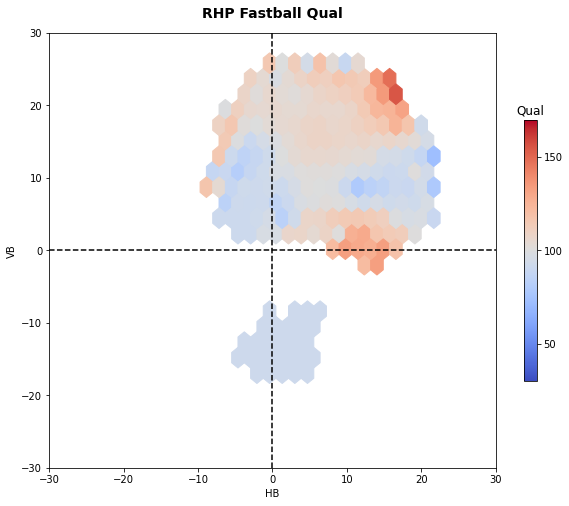

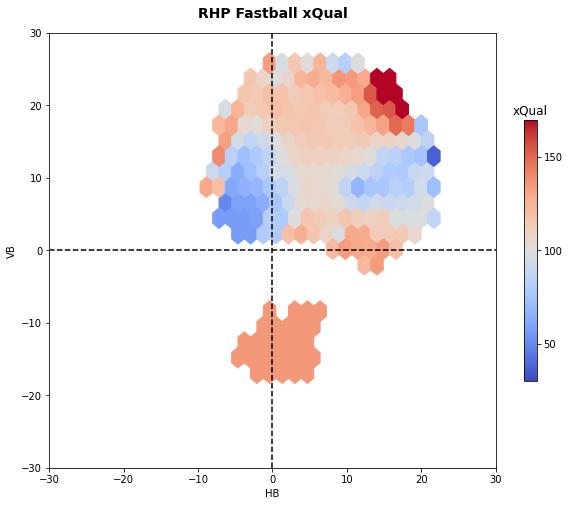

In [14]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP 4-Seam HB & VB

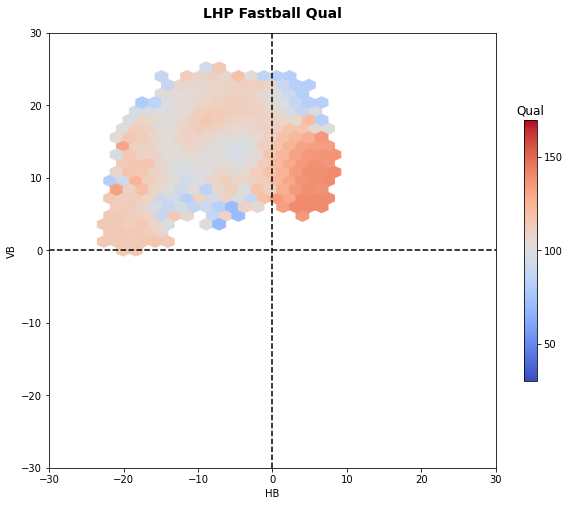

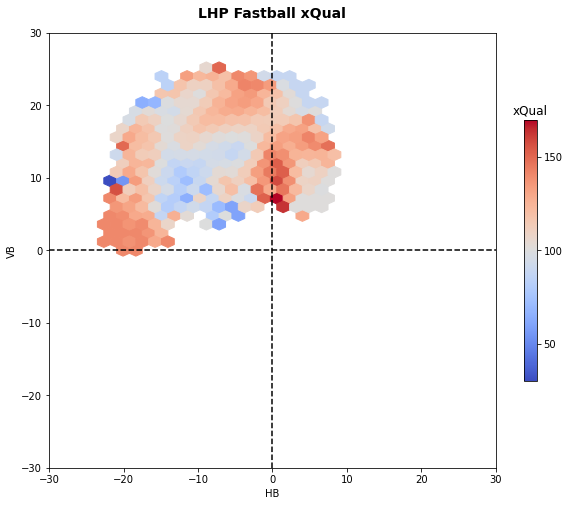

In [15]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Cutter Analysis

In [16]:
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']

fc_r_avg = fc_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
fc_l_avg = fc_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
fc_avg = pd.concat([fc_r_avg, fc_l_avg], ignore_index = True)
fc_avg = fc_avg.round(1)
fc_avg.head()

,pitch_type,p_throws,velo,pfx_x,pfx_z,release_extension,arm_angle
0,FC,R,89.5,-3.0,7.9,6.3,30.5
1,FC,L,86.8,1.7,7.9,6.2,69.0


In [17]:
fc_stats[['rv', 'xRV']].describe()

,rv,xRV
count,47445.000000,47445.000000
mean,0.003665,0.006626
std,0.259991,0.149779
min,-1.860000,-1.137520
25%,0.000000,-0.024800
50%,0.000000,-0.001920
75%,0.000000,0.022040
max,3.340000,2.192300


### Top 10 Cutter xQual

In [18]:
fc_stats['RV/100'] = ((fc_stats['rv'] / fc_stats['n_pitches']) * 100)
fc_stats['xRV/100'] = ((fc_stats['xRV'] / fc_stats['n_pitches']) * 100)

cols = list(fc_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
fc_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fc_stats[col_zscore] = ((fc_stats[col] - fc_stats[col].mean())/ fc_stats[col].std(ddof=0) * -1)

stats = fc_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
fc_stats = pd.merge(fc_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
fc_stats['Qual'] = fc_stats['rv_zscore_y'] + 100
fc_stats['xQual'] = fc_stats['xRV_zscore_y'] + 100
fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']
q_stats = fc_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle', 
                                             'RV/100', 'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
fc_leaders = stats.sort_values(by = ['xQual'], ascending = False)
fc_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
113,"Lynn, Lance",R,FC,775,88.67,-2.71,4.84,6.30,48.1,-14.85,-1.92,168.04,-11.05,-1.43,208.03
128,"Miley, Wade",L,FC,1204,85.38,3.97,6.91,6.06,46.5,0.28,0.02,115.90,-3.54,-0.29,176.93
194,"Thompson, Zach",R,FC,419,87.06,-3.78,5.44,6.28,23.3,-7.33,-1.75,134.10,-8.54,-2.04,175.55
31,"Burnes, Corbin",R,FC,1354,95.23,-4.19,11.17,6.38,18.1,-4.17,-0.31,135.13,-2.17,-0.16,174.42
160,"Quantrill, Cal",R,FC,585,88.42,-2.55,6.18,6.39,27.3,-7.23,-1.24,136.06,-7.24,-1.24,174.25
38,"Clase, Emmanuel",R,FC,722,100.22,-2.73,10.66,6.45,14.4,-6.69,-0.93,135.91,-6.13,-0.85,172.87
64,"Garcia, Luis",R,FC,565,86.10,-5.69,5.22,6.23,31.6,-15.60,-2.76,167.97,-6.61,-1.17,169.12
188,"Stroman, Marcus",R,FC,418,89.93,-2.01,4.88,5.88,23.8,-4.15,-0.99,121.86,-6.97,-1.67,165.01
4,"Alvarado, José",L,FC,170,94.11,1.26,5.10,6.73,25.5,-9.08,-5.34,137.32,-8.01,-4.71,161.00
49,"Detwiler, Ross",L,FC,325,85.15,0.42,4.94,5.49,56.6,-3.48,-1.07,117.97,-6.07,-1.87,154.90


In [19]:
fc_leaders.loc[fc_leaders['player_name'] == 'Cole, Gerrit']

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual


### RHP Cutter HB & VB

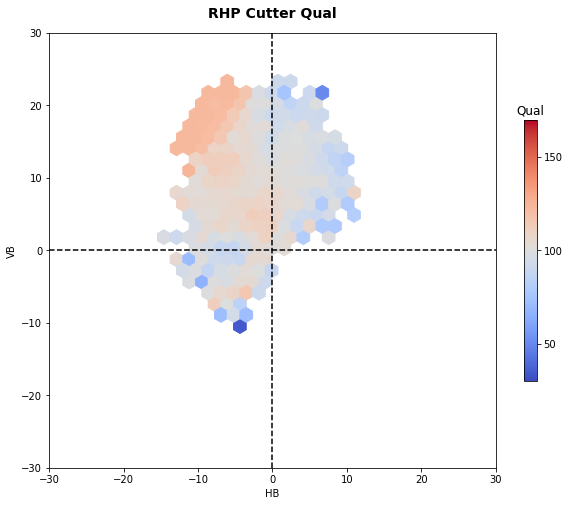

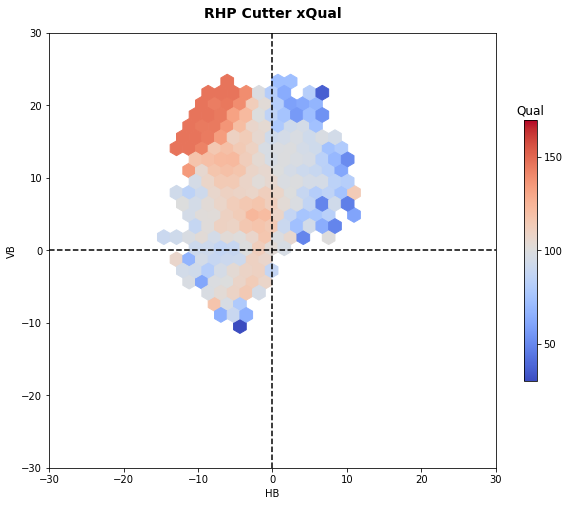

In [20]:
plt.figure(figsize = (10, 8))
plt.hexbin(fc_r_stats['pfx_x'], fc_r_stats['pfx_z'], C =fc_r_stats['Qual'], cmap ='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fc_r_stats['pfx_x'],fc_r_stats['pfx_z'],C = fc_r_stats['xQual'],cmap = 'coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Cutter HB & VB

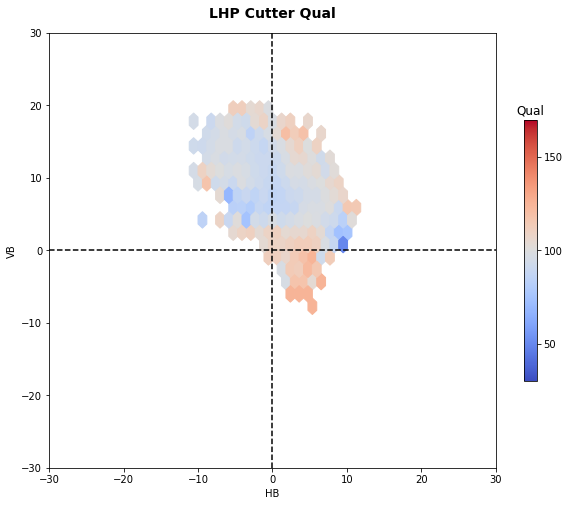

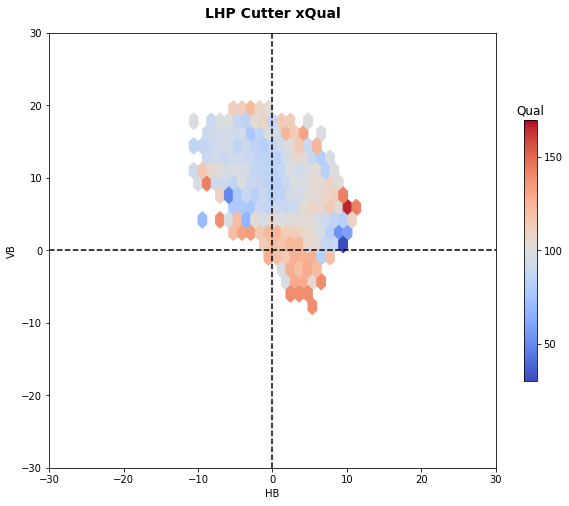

In [21]:
plt.figure(figsize = (10, 8))
plt.hexbin(fc_l_stats['pfx_x'], fc_l_stats['pfx_z'], C = fc_l_stats['Qual'],cmap='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fc_l_stats['pfx_x'], fc_l_stats['pfx_z'], C = fc_l_stats['xQual'],cmap='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Sinker Analysis

In [22]:
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
si_stats = si_stats.round(1)
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']

si_r_avg = si_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
si_l_avg = si_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
si_avg = pd.concat([si_r_avg, si_l_avg], ignore_index = True)
si_avg = si_avg.round(1)
si_avg.head()

,pitch_type,p_throws,velo,pfx_x,pfx_z,release_extension,arm_angle
0,SI,R,93.4,14.8,9.2,6.3,33.4
1,SI,L,92.1,-15.0,9.3,6.3,69.5


In [23]:
si_stats[['rv', 'xRV']].describe()

,rv,xRV
count,109151.000000,109151.000000
mean,0.009980,0.011682
std,0.260823,0.152048
min,-1.800000,-1.100000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,-0.000000
max,3.300000,2.200000


### Top 10 Sinker xQual

In [24]:
si_stats['RV/100'] = ((si_stats['rv'] / si_stats['n_pitches']) * 100)
si_stats['xRV/100'] = ((si_stats['xRV'] / si_stats['n_pitches']) * 100)

cols = list(si_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
si_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    si_stats[col_zscore] = ((si_stats[col] - si_stats[col].mean())/ si_stats[col].std(ddof=0) * -1)

stats = si_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
si_stats = pd.merge(si_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
si_stats['Qual'] = si_stats['rv_zscore_y'] + 100
si_stats['xQual'] = si_stats['xRV_zscore_y'] + 100
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']
q_stats = si_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                             'RV/100', 'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
si_leaders = stats.sort_values(by = ['xQual'], ascending = False)
si_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
216,"Houser, Adrian",R,SI,1263,93.57,15.95,7.79,6.54,25.8,-12.0,-0.95,194.33,-14.0,-1.11,289.11
436,"Suárez, Ranger",L,SI,734,92.95,-15.77,7.82,6.21,77.2,-20.4,-2.78,206.30,-19.3,-2.63,283.33
473,"Wainwright, Adam",R,SI,860,89.05,12.74,12.29,6.56,22.8,-17.0,-1.98,198.08,-14.7,-1.71,262.76
7,"Alcantara, Sandy",R,SI,874,97.61,17.27,7.34,5.95,38.9,-2.5,-0.29,143.03,-5.1,-0.58,200.69
178,"Gray, Sonny",R,SI,651,92.42,13.17,9.57,6.55,12.0,-2.4,-0.37,134.11,-6.3,-0.97,191.45
494,"Woodruff, Brandon",R,SI,749,96.24,13.96,12.77,6.47,27.4,-7.2,-0.96,156.26,-4.7,-0.63,188.46
484,"Wheeler, Zack",R,SI,580,96.70,15.70,11.43,7.21,31.3,-8.3,-1.43,154.01,-6.4,-1.10,186.65
285,"Matz, Steven",L,SI,1327,94.47,-15.04,12.30,6.46,61.1,1.5,0.11,145.02,2.4,0.18,186.17
260,"Loup, Aaron",L,SI,431,92.35,-19.52,3.86,6.11,152.0,-8.3,-1.93,148.31,-7.1,-1.65,179.81
508,"Álvarez, José",L,SI,430,91.24,-16.81,9.89,6.48,82.1,-4.5,-1.05,133.71,-5.8,-1.35,171.18


In [25]:
si_leaders.loc[si_leaders['player_name'] == 'Cole, Gerrit']

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
92,"Cole, Gerrit",R,SI,25,97.66,16.85,14.57,6.62,36.6,2.0,8.0,93.29,0.9,3.6,96.0


### RHP Sinker HB & VB

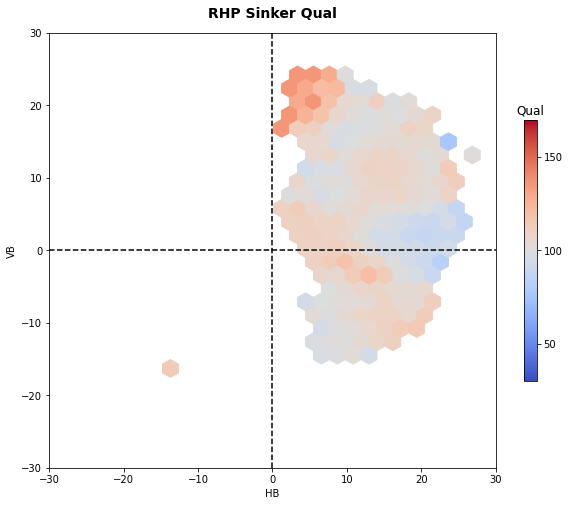

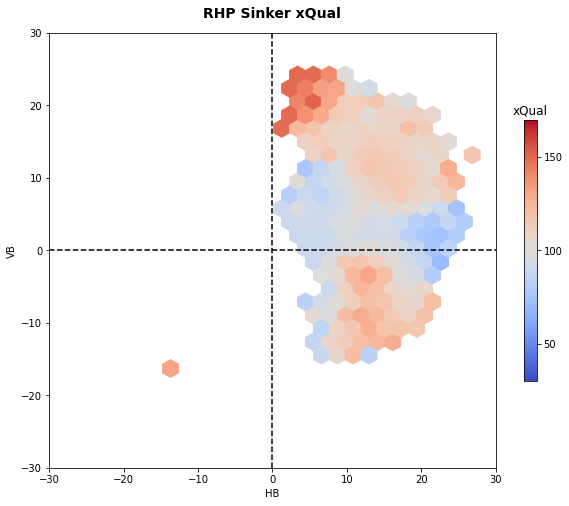

In [26]:
plt.figure(figsize = (10, 8))
plt.hexbin(si_r_stats['pfx_x'], si_r_stats['pfx_z'], C = si_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(si_r_stats['pfx_x'], si_r_stats['pfx_z'], C = si_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Sinker HB & VB

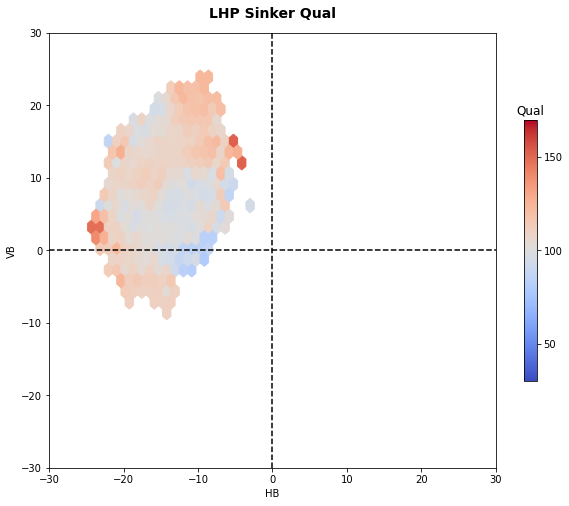

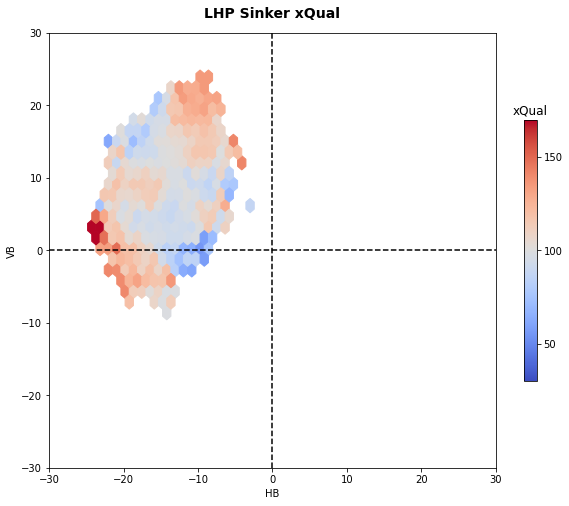

In [27]:
plt.figure(figsize = (10, 8))
plt.hexbin(si_l_stats['pfx_x'], si_l_stats['pfx_z'], C = si_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(si_l_stats['pfx_x'], si_l_stats['pfx_z'], C = si_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Slider Analysis

In [28]:
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

sl_r_avg = sl_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
sl_l_avg = sl_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()

sl_avg = pd.concat([sl_r_avg, sl_l_avg], ignore_index = True)
sl_avg = sl_avg.round(1)
sl_avg.head()

,pitch_type,p_throws,velo,pfx_x,pfx_z,release_extension,arm_angle
0,SL,R,84.9,-6.3,1.8,6.3,33.7
1,SL,L,83.9,5.8,1.5,6.2,64.0


In [29]:
sl_stats[['rv', 'xRV']].describe()

,rv,xRV
count,135534.000000,135534.000000
mean,-0.007693,-0.005802
std,0.256083,0.145309
min,-1.720000,-1.146420
25%,0.000000,-0.032280
50%,0.000000,-0.007040
75%,0.000000,0.013280
max,3.760000,2.322180


### Top 10 Slider xQual

In [30]:
sl_stats['RV/100'] = ((sl_stats['rv'] / sl_stats['n_pitches']) * 100)
sl_stats['xRV/100'] = ((sl_stats['xRV'] / sl_stats['n_pitches']) * 100)

cols = list(sl_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
sl_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    sl_stats[col_zscore] = ((sl_stats[col] - sl_stats[col].mean())/ sl_stats[col].std(ddof=0) * -1)

stats = sl_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
sl_stats = pd.merge(sl_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
sl_stats['Qual'] = sl_stats['rv_zscore_y'] + 100
sl_stats['xQual'] = sl_stats['xRV_zscore_y'] + 100
sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

q_stats = sl_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                             'RV/100', 'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
sl_leaders = stats.sort_values(by = ['xQual'], ascending = False)
sl_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
499,"Ray, Robbie",L,SL,964,88.62,0.98,7.16,6.35,81.7,-20.69,-2.15,151.84,-28.75,-2.98,259.34
516,"Rodón, Carlos",L,SL,603,85.76,8.21,-1.06,6.00,66.6,-23.71,-3.93,174.47,-23.73,-3.93,239.21
387,"McCullers Jr., Lance",R,SL,719,85.99,-13.67,4.59,5.98,34.3,-15.90,-2.21,140.49,-21.90,-3.05,222.01
426,"Musgrove, Joe",R,SL,815,84.07,-14.03,-1.56,5.89,24.5,-16.78,-2.06,141.04,-19.47,-2.39,201.48
522,"Rogers, Tyler",R,SL,479,71.76,-13.14,13.84,5.90,83.2,-22.02,-4.60,171.60,-17.04,-3.56,198.17
294,"Jackson, Luke",R,SL,562,87.52,-1.40,-5.61,6.65,37.6,-16.78,-2.99,148.64,-17.30,-3.08,196.59
391,"McHugh, Collin",R,SL,514,79.47,-18.72,-0.61,6.59,40.4,-15.58,-3.03,145.40,-16.18,-3.15,190.85
76,"Buehler, Walker",R,SL,433,84.86,-14.19,0.79,6.43,20.0,-12.93,-2.99,137.48,-15.71,-3.63,190.79
615,"Taylor, Josh",L,SL,364,87.24,5.17,4.27,6.80,79.1,-15.01,-4.12,147.68,-15.10,-4.15,189.37
111,"Clase, Emmanuel",R,SL,310,91.85,-6.20,0.81,6.40,12.1,-10.62,-3.43,132.16,-14.58,-4.70,187.96


In [31]:
sl_leaders.loc[sl_leaders['player_name'] == 'Cole, Gerrit']

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
118,"Cole, Gerrit",R,SL,659,88.39,-5.34,0.49,6.42,34.9,-11.73,-1.78,126.01,-10.89,-1.65,148.61


### RHP Slider HB & VB

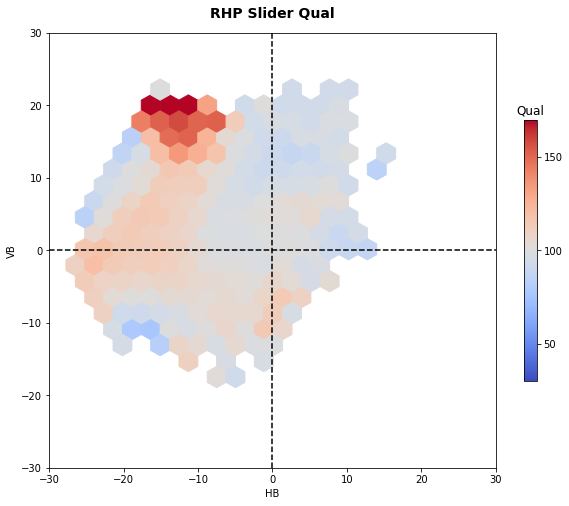

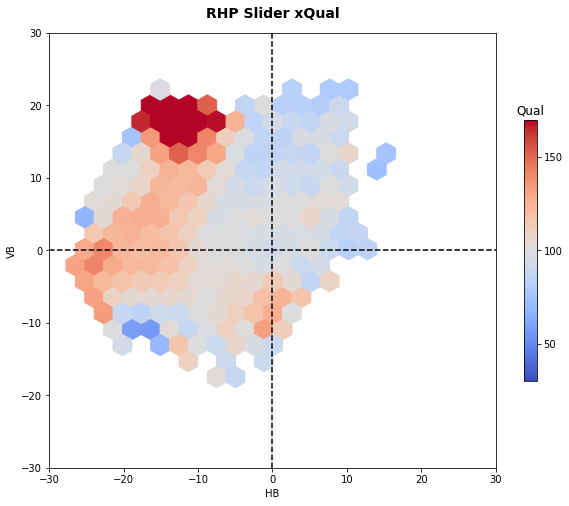

In [32]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_r_stats['pfx_x'], sl_r_stats['pfx_z'], C = sl_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(sl_r_stats['pfx_x'], sl_r_stats['pfx_z'], C = sl_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Slider HB & VB

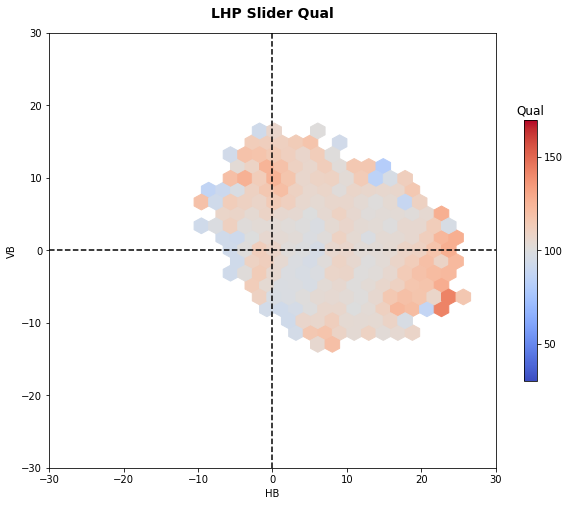

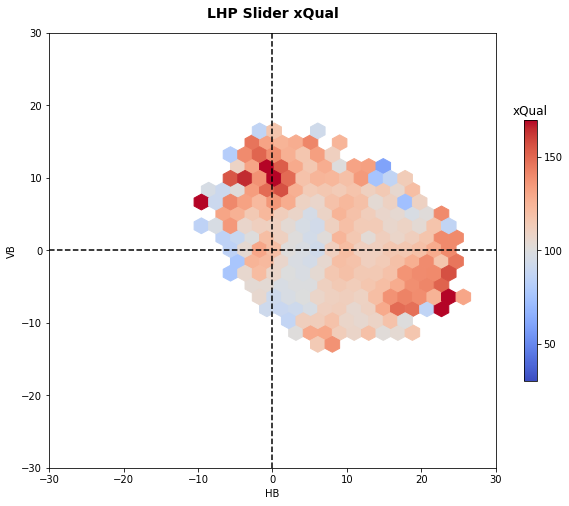

In [33]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_l_stats['pfx_x'], sl_l_stats['pfx_z'], C = sl_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(sl_l_stats['pfx_x'], sl_l_stats['pfx_z'], C = sl_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Curveball Analysis

In [34]:
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

cu_r_avg = cu_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
cu_l_avg = cu_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
cu_avg = pd.concat([cu_r_avg, cu_l_avg], ignore_index = True)
cu_avg = cu_avg.round(1)
cu_avg.head()

,pitch_type,p_throws,velo,pfx_x,pfx_z,release_extension,arm_angle
0,CU,R,79.2,-9.6,-9.3,6.2,29.3
1,CU,L,77.7,8.4,-7.5,6.1,60.0


In [35]:
cu_stats[['rv', 'xRV']].describe()

,rv,xRV
count,58770.000000,58770.000000
mean,-0.007629,-0.005919
std,0.231302,0.133946
min,-1.860000,-1.195180
25%,0.000000,-0.029400
50%,0.000000,-0.006220
75%,0.000000,0.011800
max,3.340000,2.169640


### Top 10 Curveball xQual

In [36]:
cu_stats['RV/100'] = ((cu_stats['rv'] / cu_stats['n_pitches']) * 100)
cu_stats['xRV/100'] = ((cu_stats['xRV'] / cu_stats['n_pitches']) * 100)

cols = list(cu_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
cu_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    cu_stats[col_zscore] = ((cu_stats[col] - cu_stats[col].mean())/ cu_stats[col].std(ddof=0) * -1)

stats = cu_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
cu_stats = pd.merge(cu_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
cu_stats['Qual'] = cu_stats['rv_zscore_y'] + 100
cu_stats['xQual'] = cu_stats['xRV_zscore_y'] + 100
cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

q_stats = cu_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                             'RV/100', 'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
cu_leaders = stats.sort_values(by = ['xQual'], ascending = False)
cu_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
293,"Morton, Charlie",R,CU,1095,80.64,-16.57,-10.06,6.25,38.1,-27.38,-2.50,182.26,-32.76,-2.99,296.19
431,"Valdez, Framber",L,CU,643,77.92,13.52,-15.30,5.85,33.2,-21.47,-3.34,171.61,-26.05,-4.05,266.08
296,"Musgrove, Joe",R,CU,698,82.07,-11.02,-13.68,5.90,21.7,-19.70,-2.82,162.15,-22.61,-3.24,237.92
429,"Urías, Julio",L,CU,952,81.38,15.78,-0.93,5.55,45.9,-22.66,-2.38,166.57,-23.63,-2.48,234.33
287,"Montgomery, Jordan",L,CU,606,79.98,0.95,-3.96,6.53,46.3,-12.04,-1.99,132.07,-15.14,-2.50,186.26
147,"Glasnow, Tyler",R,CU,183,83.50,-4.63,-17.54,7.17,27.0,-11.41,-6.23,143.29,-12.48,-6.82,185.07
59,"Burnes, Corbin",R,CU,473,81.20,-11.27,-7.84,6.32,11.7,-17.97,-3.80,162.09,-13.58,-2.87,180.51
454,"Woodruff, Brandon",R,CU,468,83.76,-4.54,-12.31,6.37,26.5,-11.65,-2.49,134.93,-11.32,-2.42,163.85
132,"Fried, Max",L,CU,657,74.44,8.29,-15.42,6.19,38.5,-13.46,-2.05,136.52,-12.18,-1.85,161.87
436,"Wainwright, Adam",R,CU,1027,73.47,-16.59,-14.75,6.36,21.9,-15.85,-1.54,134.65,-14.25,-1.39,161.02


In [37]:
cu_leaders.loc[cu_leaders['player_name'] == 'Cole, Gerrit']

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual


### RHP Curveball HB & VB

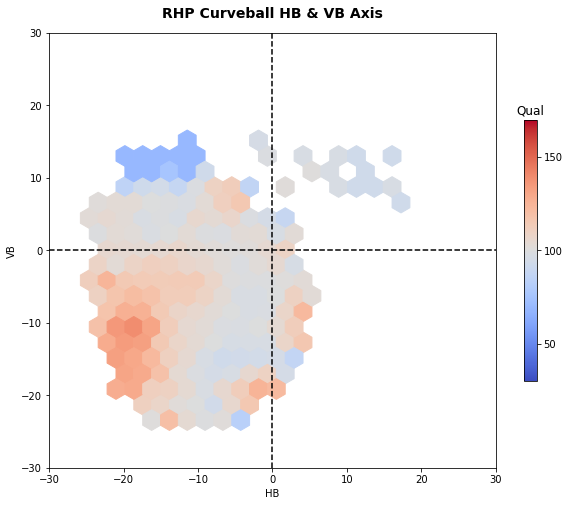

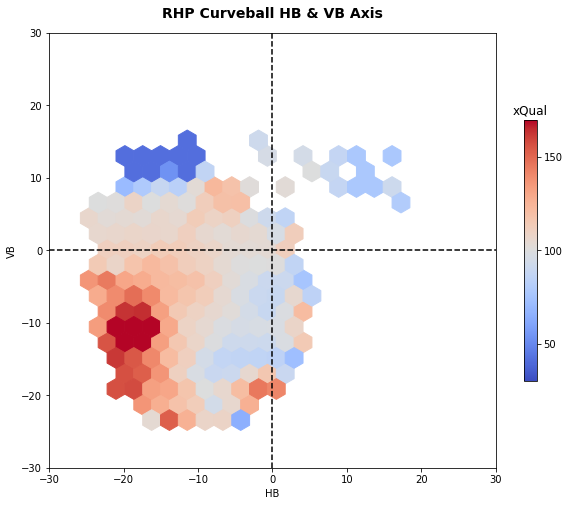

In [38]:
plt.figure(figsize = (10, 8))
plt.hexbin(cu_r_stats['pfx_x'], cu_r_stats['pfx_z'], C = cu_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(cu_r_stats['pfx_x'], cu_r_stats['pfx_z'], C = cu_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Curveball HB & VB

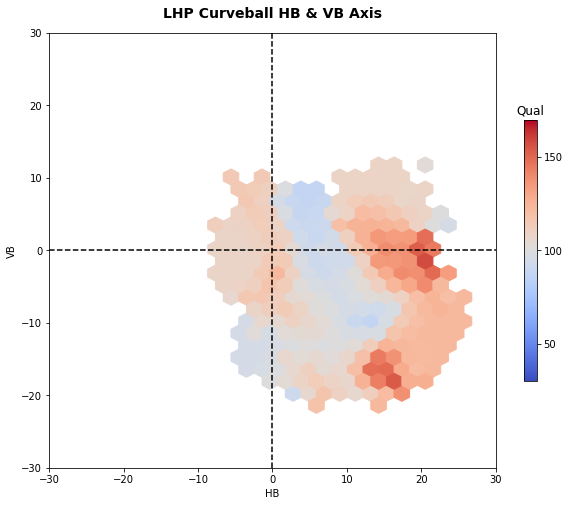

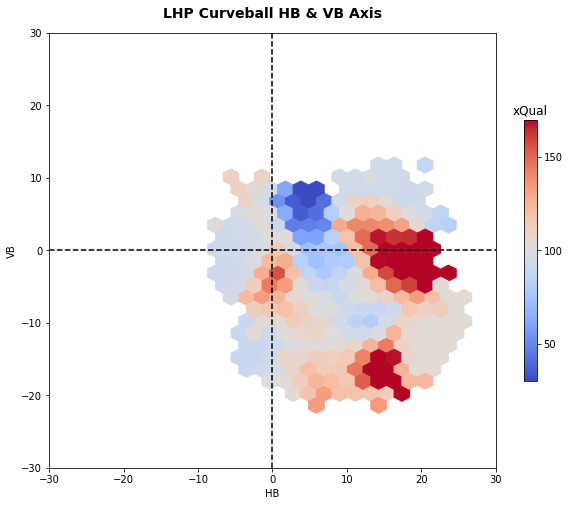

In [39]:
plt.figure(figsize = (10, 8))
plt.hexbin(cu_l_stats['pfx_x'], cu_l_stats['pfx_z'], C = cu_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(cu_l_stats['pfx_x'], cu_l_stats['pfx_z'], C = cu_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Changeup Analysis

In [40]:
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']
ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

ch_r_avg = ch_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()
ch_l_avg = ch_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle'].mean()

ch_avg = pd.concat([ch_r_avg, ch_l_avg], ignore_index = True)
ch_avg = ch_avg.round(1)
ch_avg.head()

,pitch_type,p_throws,velo,pfx_x,pfx_z,release_extension,arm_angle
0,CH,R,85.5,13.8,6.3,6.3,33.8
1,CH,L,83.6,-13.9,7.8,6.2,65.9


In [41]:
ch_stats[['rv', 'xRV']].describe()

,rv,xRV
count,80338.000000,80338.000000
mean,-0.003034,-0.000706
std,0.258732,0.146780
min,-1.720000,-1.149700
25%,0.000000,-0.030060
50%,0.000000,-0.005080
75%,0.000000,0.016660
max,3.340000,2.209680


### Top 10 Changeup xQual

In [42]:
ch_stats['RV/100'] = ((ch_stats['rv'] / ch_stats['n_pitches']) * 100)
ch_stats['xRV/100'] = ((ch_stats['xRV'] / ch_stats['n_pitches']) * 100)

cols = list(ch_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
ch_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    ch_stats[col_zscore] = ((ch_stats[col] - ch_stats[col].mean())/ ch_stats[col].std(ddof=0) * -1)

stats = ch_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
ch_stats = pd.merge(ch_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
ch_stats['Qual'] = ch_stats['rv_zscore_y'] + 100
ch_stats['xQual'] = ch_stats['xRV_zscore_y'] + 100
ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

q_stats = ch_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                             'RV/100', 'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                                 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
ch_leaders = stats.sort_values(by = ['xQual'], ascending = False)
ch_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
101,"Castillo, Luis",R,CH,952,88.33,16.77,0.94,5.57,47.6,-15.59,-1.64,149.09,-26.00,-2.73,272.57
564,"Sulser, Cole",R,CH,355,83.96,13.49,5.60,6.70,32.6,-16.86,-4.75,161.00,-15.49,-4.36,203.81
519,"Scherzer, Max",R,CH,421,84.98,15.16,3.95,6.44,49.4,-11.50,-2.73,139.51,-13.39,-3.18,189.22
594,"Urías, Julio",L,CH,483,86.81,-14.58,7.23,5.80,51.5,-12.95,-2.68,144.39,-13.13,-2.72,187.10
491,"Rodríguez, Joely",L,CH,284,88.35,-11.20,0.34,6.34,133.5,-8.88,-3.13,130.99,-12.31,-4.34,182.51
403,"Montgomery, Jordan",L,CH,626,82.48,-9.74,14.71,6.65,44.6,-6.91,-1.10,119.37,-11.62,-1.86,176.14
189,"Flexen, Chris",R,CH,431,82.70,12.22,9.60,5.98,15.6,-14.94,-3.47,152.69,-11.39,-2.64,175.50
54,"Berríos, José",R,CH,401,84.84,13.89,4.50,6.50,50.2,-10.71,-2.67,136.69,-10.16,-2.53,167.26
627,"Williams, Devin",R,CH,621,83.72,16.96,-4.16,6.84,40.4,-12.34,-1.99,140.41,-9.95,-1.60,164.83
561,"Stripling, Ross",R,CH,258,83.13,10.17,10.65,6.01,23.1,-8.29,-3.21,129.02,-8.48,-3.29,156.54


In [43]:
ch_leaders.loc[ch_leaders['player_name'] == 'Cole, Gerrit']

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_extension,arm_angle,rv,RV/100,Qual,xRV,xRV/100,xQual
118,"Cole, Gerrit",R,CH,420,89.84,15.82,9.99,6.69,36.4,-2.68,-0.64,105.43,-2.74,-0.65,116.68


### RHP Changeup HB & VB

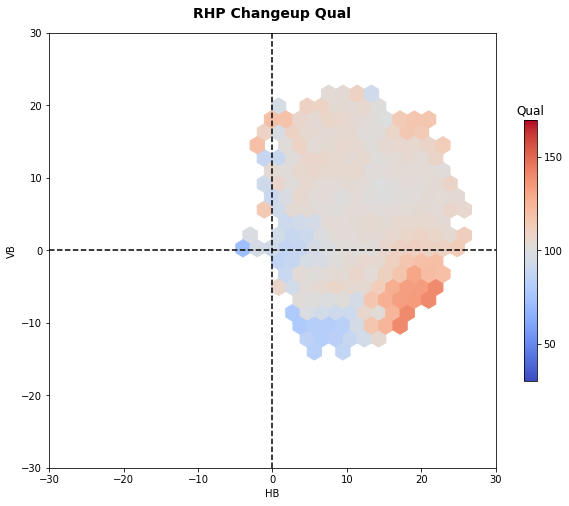

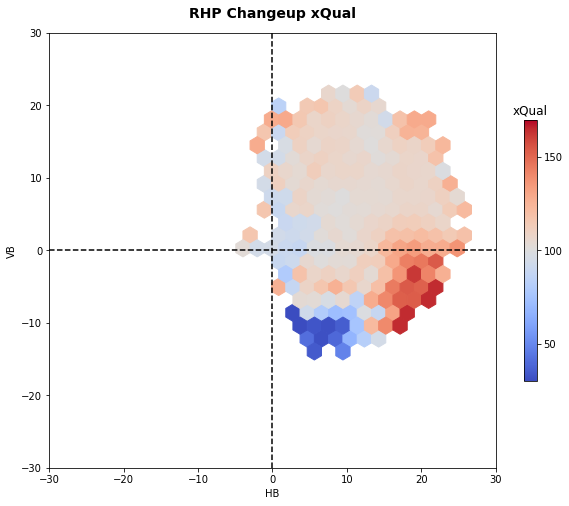

In [44]:
plt.figure(figsize = (10, 8))
plt.hexbin(ch_r_stats['pfx_x'], ch_r_stats['pfx_z'], C = ch_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ch_r_stats['pfx_x'], ch_r_stats['pfx_z'], C = ch_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Changeup HB & VB

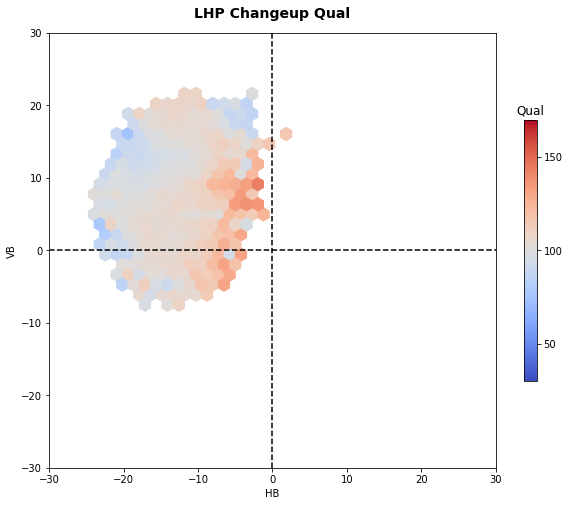

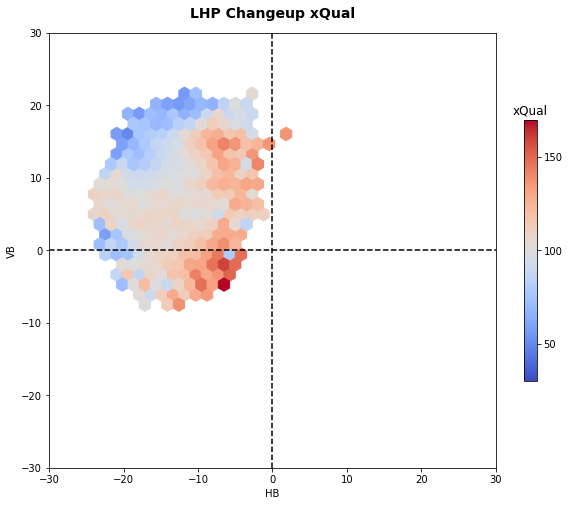

In [45]:
plt.figure(figsize = (10, 8))
plt.hexbin(ch_l_stats['pfx_x'], ch_l_stats['pfx_z'], C = ch_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ch_l_stats['pfx_x'], ch_l_stats['pfx_z'], C = ch_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup xQual', fontsize = 14, fontweight = 'bold', pad = 15);